In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from scipy.stats import zscore

import pickle

Data exploration and feature engineering below was done with the help of ChatGPT and example kaggle dataset explorations.

# Explore Dataset

In [2]:
events_df = pd.read_csv('retail_rocket/events.csv')

item_properties_p1 = pd.read_csv('retail_rocket/item_properties_part1.csv')
item_properties_p2 = pd.read_csv('retail_rocket/item_properties_part2.csv')
item_properties_df = pd.concat([item_properties_p1, item_properties_p2], ignore_index=True)

del item_properties_p1, item_properties_p2

category_tree_df = pd.read_csv('retail_rocket/category_tree.csv')

In [3]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
# Ensure event types are valid
valid_events = ['view', 'addtocart', 'transaction']
events_df = events_df[events_df['event'].isin(valid_events)]

events_df = events_df.dropna()

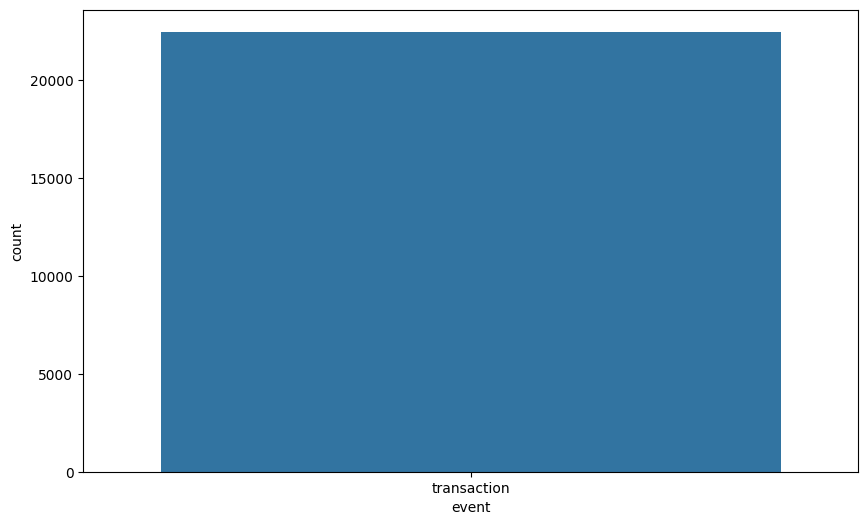

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data=events_df, x='event', hue='event', legend=False)
plt.show()

In [6]:
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [7]:
category_tree_df.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [8]:
events_df.shape, category_tree_df.shape, item_properties_df.shape

((22457, 5), (1669, 2), (20275902, 4))

In [9]:
events_df.isnull().sum()

timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
dtype: int64

In [10]:
events_count = events_df.event.value_counts()
events_count

event
transaction    22457
Name: count, dtype: int64

In [11]:
(events_count /len(events_df)) * 100  # Percentages of event types

event
transaction    100.0
Name: count, dtype: float64

In [12]:
events_df.groupby('event')['transactionid'].count()

event
transaction    22457
Name: transactionid, dtype: int64

In [13]:
events_df.groupby('event')['visitorid'].count()

event
transaction    22457
Name: visitorid, dtype: int64

In [14]:
print('Number of rows before removing duplicates: ', events_df.shape[0])

# Remove duplicates based on all columns
events_df.drop_duplicates(inplace=True)
events_df.reset_index(drop=True, inplace=True)

print('Number of rows after removing duplicates: ', events_df.shape[0])

Number of rows before removing duplicates:  22457
Number of rows after removing duplicates:  22457


In [15]:
events_df['date_time'] = pd.to_datetime(events_df['timestamp'],unit='ms')
events_df['date_time']

0       2015-06-02 05:17:56.276
1       2015-06-01 21:18:20.981
2       2015-06-01 21:25:15.008
3       2015-06-01 16:38:56.375
4       2015-06-01 16:01:58.180
                  ...          
22452   2015-07-31 21:12:56.570
22453   2015-07-31 21:57:58.779
22454   2015-07-31 15:48:50.123
22455   2015-07-31 15:12:40.300
22456   2015-07-31 16:09:49.163
Name: date_time, Length: 22457, dtype: datetime64[ns]

In [16]:
item_tra = events_df[['visitorid','itemid','date_time']][events_df['event']=='transaction']
item_view = events_df[['visitorid','itemid','date_time']][events_df['event']=='view']
item_atc = events_df[['visitorid','itemid','date_time']][events_df['event']=='addtocart']

m = item_tra.merge(item_atc, on=['visitorid','itemid'], how ='inner', suffixes=[' (transaction)',' (addtocart)'])
m = m.merge(item_view, on=['visitorid','itemid'], how ='inner', suffixes =['(view)'])
m = m.rename(columns={'date_time' : 'date_time (view)'})
m.head(10)

,visitorid,itemid,date_time (transaction),date_time (addtocart),date_time (view)


In [17]:
# Distribution of events by day of the week and hour of the day. 
events_df['day_of_week'] = events_df['date_time'].dt.day_name()
events_df['hour'] = events_df['date_time'].dt.hour

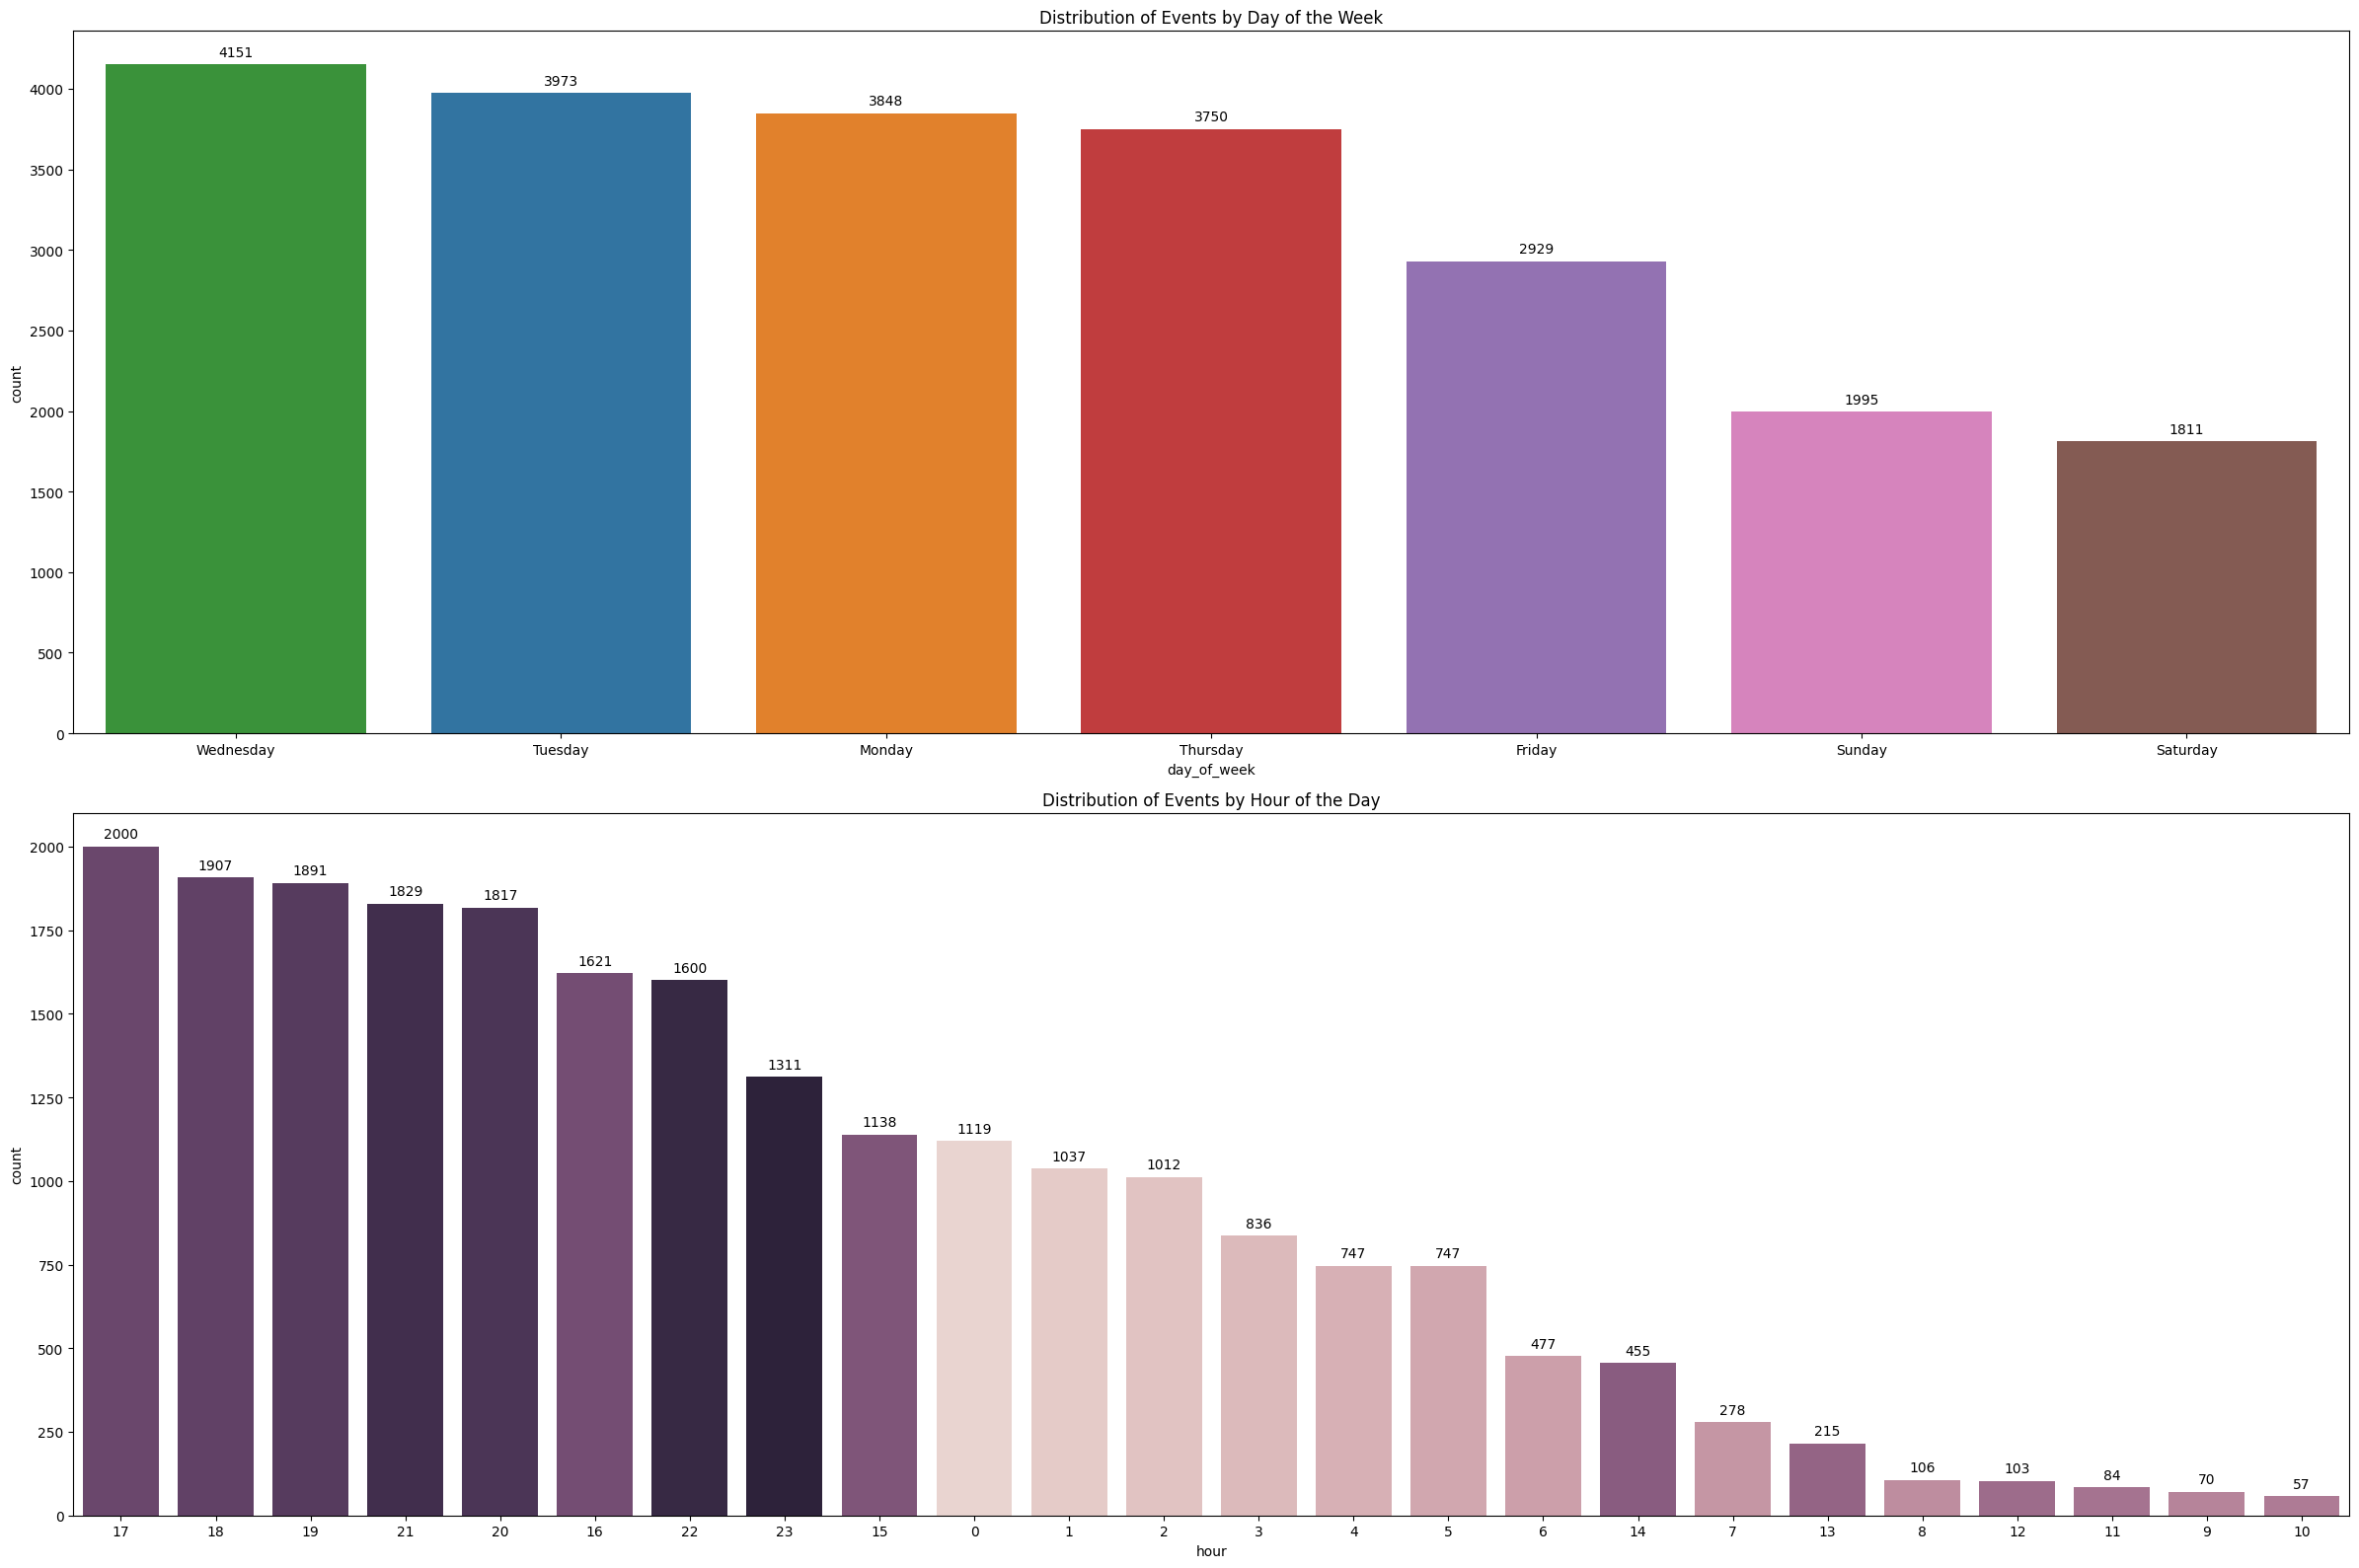

In [18]:
plt.figure(figsize=(24, 16))

plt.subplot(2, 1, 1)
ax1 = sns.countplot(data=events_df, x='day_of_week', hue='day_of_week', order=events_df['day_of_week'].value_counts().index, legend=False)
plt.title('Distribution of Events by Day of the Week')
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.subplot(2, 1, 2)
ax2 = sns.countplot(data=events_df, x='hour', hue='hour', order=events_df['hour'].value_counts().index, legend=False)
plt.title('Distribution of Events by Hour of the Day')
for p in ax2.patches:
    ax2.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.show()

Series([], Name: count, dtype: int64)


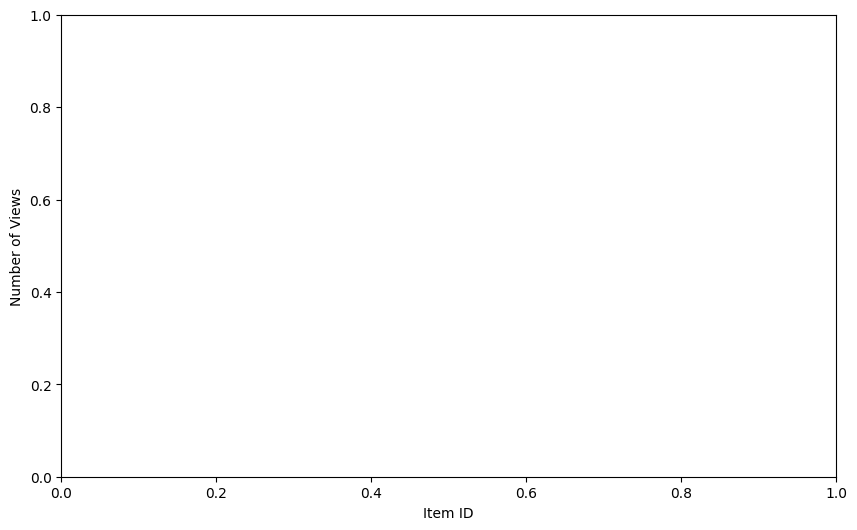

In [19]:
top_viewed_items = events_df[events_df['event'] == 'view']['itemid'].value_counts().head(10)
print(top_viewed_items)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_viewed_items.index, hue=top_viewed_items.index, y=top_viewed_items.values, legend=False)
plt.xlabel('Item ID')
plt.ylabel('Number of Views')
plt.show()

itemid
461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
Name: count, dtype: int64


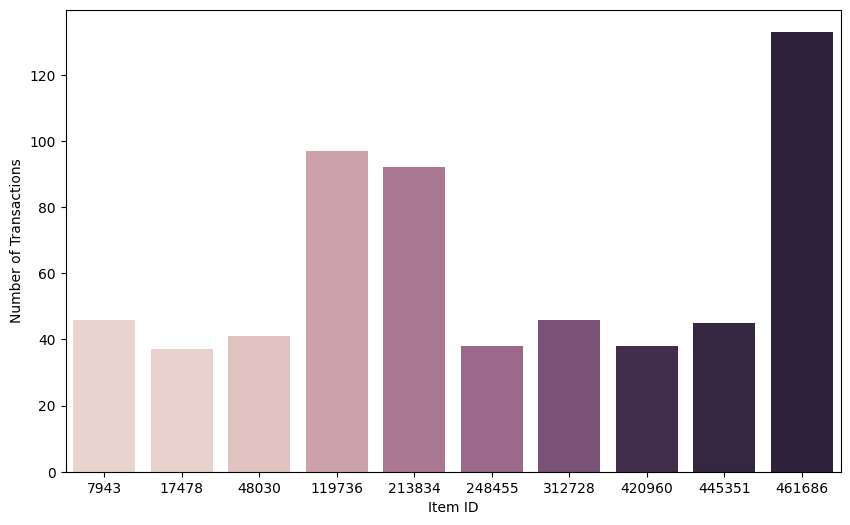

In [20]:
top_sold_items = events_df[events_df['event'] == 'transaction']['itemid'].value_counts().head(10)
print(top_sold_items)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sold_items.index, hue=top_sold_items.index, y=top_sold_items.values, legend=False)
plt.xlabel('Item ID')
plt.ylabel('Number of Transactions')
plt.show()

Series([], Name: count, dtype: int64)


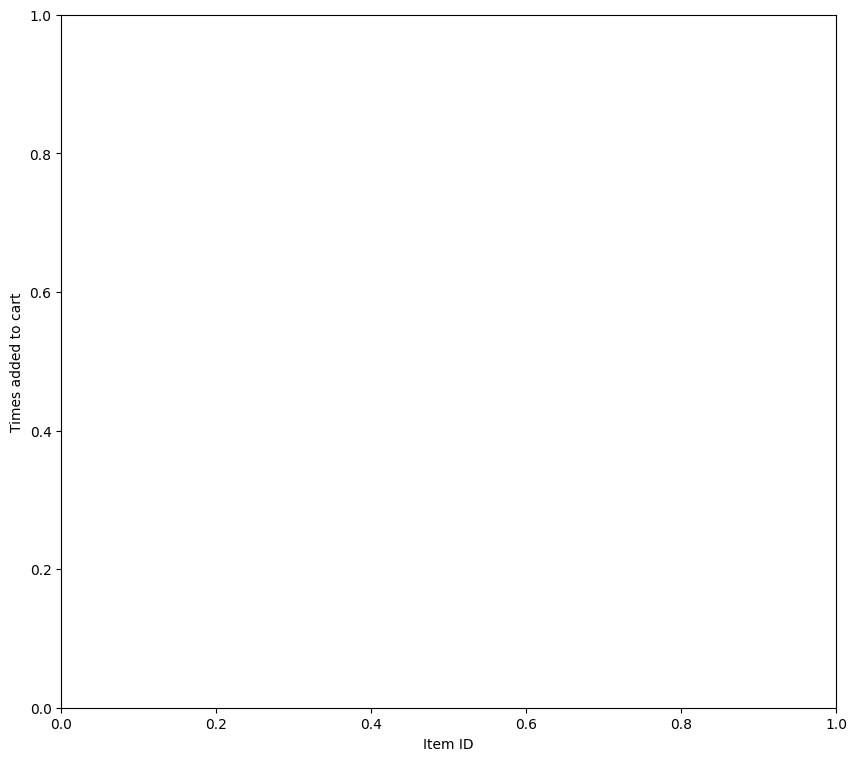

In [21]:
top_addtocart_item = events_df[events_df['event']=='addtocart']['itemid'].value_counts().head(10)
print(top_addtocart_item)

plt.figure(figsize=(10,9))
sns.barplot(x=top_addtocart_item.index, hue=top_addtocart_item.index, y=top_addtocart_item.values, legend=False)
plt.xlabel('Item ID')
plt.ylabel('Times added to cart')

plt.show()

In [22]:
# Calculate total number of events for each user and item
user_interaction_counts = events_df.groupby('visitorid')['event'].count().reset_index()
user_interaction_counts.rename(columns={'event': 'total_events_user'}, inplace=True)

item_interaction_counts = events_df.groupby('itemid')['event'].count().reset_index()
item_interaction_counts.rename(columns={'event': 'total_events_item'}, inplace=True)

# Calculate total number of unique items interacted with by each user
user_unique_items = events_df.groupby('visitorid')['itemid'].nunique().reset_index()
user_unique_items.rename(columns={'itemid': 'unique_items_interacted'}, inplace=True)

# Calculate total number of unique users interacting with each item
item_unique_users = events_df.groupby('itemid')['visitorid'].nunique().reset_index()
item_unique_users.rename(columns={'visitorid': 'unique_users_interacted'}, inplace=True)

events_df = events_df.merge(user_interaction_counts, on='visitorid', how='left')
events_df = events_df.merge(item_interaction_counts, on='itemid', how='left')
events_df = events_df.merge(user_unique_items, on='visitorid', how='left')
events_df = events_df.merge(item_unique_users, on='itemid', how='left')

In [23]:
events_df['interaction_value'] = events_df['event'].apply(lambda x: 0.4 if x == 'view' else (0.6 if x == 'addtocart' else 0.8))

In [24]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,total_events_user,total_events_item,unique_items_interacted,unique_users_interacted,interaction_value
0,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276,Tuesday,5,1,2,1,2,0.8
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981,Monday,21,11,1,11,1,0.8
2,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008,Monday,21,1,1,1,1,0.8
3,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,Monday,16,2,2,2,2,0.8
4,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180,Monday,16,2,1,2,1,0.8


In [25]:
item_properties_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [26]:
len(set(item_properties_df.property))

1104

# Customer Behaviour Exploration

In [27]:
events_df.visitorid.size

22457

In [28]:
all_customers = events_df.visitorid.unique()
all_customers.size

11719

In [29]:
customers_who_purchased = events_df[events_df.transactionid.notnull()].visitorid.unique()
customers_who_purchased.size

11719

In [30]:
customers_only_browsed = [x for x in all_customers if x not in customers_who_purchased]
len(customers_only_browsed)

0

In [31]:
# Buying journey of random customer
events_df[events_df.visitorid == 102019].sort_values('timestamp')

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,total_events_user,total_events_item,unique_items_interacted,unique_users_interacted,interaction_value
3,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,Monday,16,2,2,2,2,0.8
174,1433176736422,102019,transaction,49521,13556.0,2015-06-01 16:38:56.422,Monday,16,2,1,2,1,0.8


In [32]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid,date_time,day_of_week,hour,total_events_user,total_events_item,unique_items_interacted,unique_users_interacted,interaction_value
0,1433222276276,599528,transaction,356475,4000.0,2015-06-02 05:17:56.276,Tuesday,5,1,2,1,2,0.8
1,1433193500981,121688,transaction,15335,11117.0,2015-06-01 21:18:20.981,Monday,21,11,1,11,1,0.8
2,1433193915008,552148,transaction,81345,5444.0,2015-06-01 21:25:15.008,Monday,21,1,1,1,1,0.8
3,1433176736375,102019,transaction,150318,13556.0,2015-06-01 16:38:56.375,Monday,16,2,2,2,2,0.8
4,1433174518180,189384,transaction,310791,7244.0,2015-06-01 16:01:58.180,Monday,16,2,1,2,1,0.8


In [33]:
user_behavior_df = events_df.groupby('visitorid').agg({
    'itemid':'count',
    'timestamp': ['min' ,'max','mean']
}).reset_index()

user_behavior_df.columns = ['visitorid', 'item_count', 'first_interaction', 'last_interaction', 'avg_interaction_time']
user_behavior_df['time_on_platform'] = user_behavior_df['last_interaction'] - user_behavior_df['first_interaction']
user_behavior_df['time_between_actions'] = user_behavior_df['time_on_platform'] / (user_behavior_df['item_count'] - 1)

In [34]:
user_behavior_df.head()

,visitorid,item_count,first_interaction,last_interaction,avg_interaction_time,time_on_platform,time_between_actions
0,172,2,1439602141230,1439602141686,1.439602e+12,456,456.0
1,186,1,1439397297040,1439397297040,1.439397e+12,0,NaN
2,264,2,1441647285614,1441647285708,1.441647e+12,94,94.0
3,419,1,1438146192695,1438146192695,1.438146e+12,0,NaN
4,539,1,1434433178673,1434433178673,1.434433e+12,0,NaN


In [35]:
item_popularity_df = events_df.groupby('itemid').agg({
    'visitorid':'count',
     'event': ['nunique',lambda  x : sum(x == 'view'),
              lambda x:sum(x =='addtocart'),
              lambda x:sum(x =='transaction')]
   }).reset_index()

item_popularity_df.columns=['itemid','user_count','event_count','view_count','addtocart_count','transaction_count']
item_popularity_df['conversion rate'] = item_popularity_df['transaction_count'] / item_popularity_df['addtocart_count']

In [36]:
item_popularity_df.head()

,itemid,user_count,event_count,view_count,addtocart_count,transaction_count,conversion rate
0,15,1,1,0,0,1,inf
1,19,1,1,0,0,1,inf
2,25,2,1,0,0,2,inf
3,42,1,1,0,0,1,inf
4,147,4,1,0,0,4,inf


In [37]:
#user_item interaction feature
user_item_interaction_df = events_df.groupby(['visitorid' ,'itemid']).agg({
    'event':'count',
    'timestamp' : ['min' ,'max']
    }).reset_index()
user_item_interaction_df.columns =['visitorid','itemid' ,'interaction_count','first_interaction','last_interaction']
user_item_interaction_df['time_between_interaction'] = user_item_interaction_df['last_interaction'] -user_item_interaction_df['first_interaction']
user_item_interaction_df

,visitorid,itemid,interaction_count,first_interaction,last_interaction,time_between_interaction
0,172,10034,1,1439602141686,1439602141686,0
1,172,465522,1,1439602141230,1439602141230,0
2,186,49029,1,1439397297040,1439397297040,0
3,264,161949,1,1441647285708,1441647285708,0
4,264,459835,1,1441647285614,1441647285614,0
...,...,...,...,...,...,...
21265,1406787,336832,1,1433177808042,1433177808042,0
21266,1406981,436004,1,1431988101266,1431988101266,0
21267,1407070,215596,1,1431556875160,1431556875160,0
21268,1407110,360922,1,1438729885624,1438729885624,0


In [38]:
# Remove non-telling features
user_feature = user_behavior_df.drop(['first_interaction' ,'last_interaction'],axis=1)
item_feature = item_popularity_df.drop(['view_count','addtocart_count','transaction_count'],axis=1)
user_item_interaction_feature = user_item_interaction_df.drop(['first_interaction','last_interaction'],axis=1)

features_df = user_item_interaction_feature.merge(user_feature,on='visitorid').merge(item_feature, on='itemid')

In [39]:
features_df.head()

,visitorid,itemid,interaction_count,time_between_interaction,item_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,172,10034,1,0,2,1.439602e+12,456,456.0,4,1,inf
1,172,465522,1,0,2,1.439602e+12,456,456.0,10,1,inf
2,186,49029,1,0,1,1.439397e+12,0,NaN,3,1,inf
3,264,161949,1,0,2,1.441647e+12,94,94.0,1,1,inf
4,264,459835,1,0,2,1.441647e+12,94,94.0,4,1,inf


In [40]:
features_df = features_df.replace([np.inf,-np.inf],np.nan)

# Fill NaN values with the median
features=features_df.fillna(features_df.median())
features.head(10)

,visitorid,itemid,interaction_count,time_between_interaction,item_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,172,10034,1,0,2,1.439602e+12,456,456.0,4,1,NaN
1,172,465522,1,0,2,1.439602e+12,456,456.0,10,1,NaN
2,186,49029,1,0,1,1.439397e+12,0,11270122.0,3,1,NaN
3,264,161949,1,0,2,1.441647e+12,94,94.0,1,1,NaN
4,264,459835,1,0,2,1.441647e+12,94,94.0,4,1,NaN
5,419,19278,1,0,1,1.438146e+12,0,11270122.0,5,1,NaN
6,539,94371,1,0,1,1.434433e+12,0,11270122.0,1,1,NaN
7,627,414182,1,0,1,1.440104e+12,0,11270122.0,1,1,NaN
8,795,207825,1,0,1,1.439244e+12,0,11270122.0,5,1,NaN
9,914,382946,1,0,1,1.439859e+12,0,11270122.0,2,1,NaN


# Filter Abnormal User Behaviour
This is acomplished with z-score statistics. The aim is to get rid of bias and later only train on the 'average' user experience.

In [41]:
columns_to_filter = ['interaction_count', 'time_between_interaction', 'item_count', 'time_on_platform']

features_df[columns_to_filter] = features_df[columns_to_filter].apply(zscore)

# Define a threshold for filtering outliers
z_score_threshold = 3
filtered_features_df = features_df[(features_df[columns_to_filter].abs() < z_score_threshold).all(axis=1)]

print('Shape before filtering:', features_df.shape)
print('Shape after filtering:', filtered_features_df.shape)

Shape before filtering: (21270, 11)
Shape after filtering: (19447, 11)


In [42]:
features_df = filtered_features_df

In [43]:
features_df.head(5)

,visitorid,itemid,interaction_count,time_between_interaction,item_count,avg_interaction_time,time_on_platform,time_between_actions,user_count,event_count,conversion rate
0,172,10034,-0.191796,-0.071393,-0.386080,1.439602e+12,-0.465648,456.0,4,1,NaN
1,172,465522,-0.191796,-0.071393,-0.386080,1.439602e+12,-0.465648,456.0,10,1,NaN
2,186,49029,-0.191796,-0.071393,-0.395606,1.439397e+12,-0.465648,NaN,3,1,NaN
3,264,161949,-0.191796,-0.071393,-0.386080,1.441647e+12,-0.465648,94.0,1,1,NaN
4,264,459835,-0.191796,-0.071393,-0.386080,1.441647e+12,-0.465648,94.0,4,1,NaN


In [44]:
visitor_ids_to_keep = set(features_df.visitorid) # Keep the non-filtered users
filtered_events_df = events_df[events_df['visitorid'].isin(visitor_ids_to_keep)]

len(events_df), len(filtered_events_df)

(22457, 20282)

In [45]:
with open('events_df_cleaned.df', 'wb') as f:
    pickle.dump(filtered_events_df, f)